In [1]:
#importing necessary packages
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline 
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from skimage.feature import hog

In [2]:
def convert_color(img, conv='RGB2YCrCb'):
    if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
                
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [3]:
#vehicle directories 
dir_1=glob.glob('/Users/Enkay/Documents/Viky/python/self-driving/vehicledetection/vehicles/GTI_Far/*.png')
dir_2=glob.glob('/Users/Enkay/Documents/Viky/python/self-driving/vehicledetection/vehicles/GTI_Left/*.png')
dir_3=glob.glob('/Users/Enkay/Documents/Viky/python/self-driving/vehicledetection/vehicles/GTI_MiddleClose/*.png')
dir_4=glob.glob('/Users/Enkay/Documents/Viky/python/self-driving/vehicledetection/vehicles/GTI_Right/*.png')
dir_5=glob.glob('/Users/Enkay/Documents/Viky/python/self-driving/vehicledetection/vehicles/KITTI_extracted/*.png')
cars=np.concatenate((dir_1,dir_2,dir_3,dir_4,dir_5))
#non vehicle directories 
nv_dir_1=glob.glob('/Users/Enkay/Documents/Viky/python/self-driving/vehicledetection/non-vehicles/Extras/*.png')
nv_dir_2=glob.glob('/Users/Enkay/Documents/Viky/python/self-driving/vehicledetection/non-vehicles/GTI/*.png')
notcars=np.concatenate((nv_dir_1,nv_dir_2))

In [4]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [20]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [450, 700]

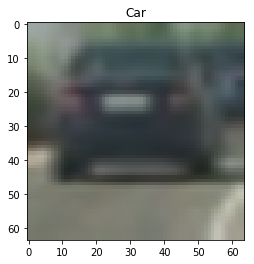

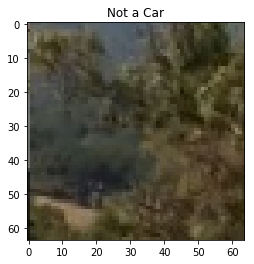

In [6]:
plt.figure()
test_car=plt.imread(cars[1])
plt.title('Car')
plt.imshow(test_car)
plt.show()
plt.figure()
plt.title('Not a Car')
test_not_car=plt.imread(notcars[1])
plt.imshow(test_not_car)
plt.show()

In [7]:
test_car_cspace= cv2.cvtColor(test_car, cv2.COLOR_RGB2YCrCb)
test_not_car_cspace= cv2.cvtColor(test_not_car, cv2.COLOR_RGB2YCrCb)
feat_ch1,img_ch1=(get_hog_features(test_car_cspace[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True))
feat_ch2,img_ch2=(get_hog_features(test_car_cspace[:,:,1], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True))
feat_ch3,img_ch3=(get_hog_features(test_car_cspace[:,:,2], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True))
feat_ch1_nc,img_ch1_nc=(get_hog_features(test_not_car_cspace[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True))
feat_ch2_nc,img_ch2_nc=(get_hog_features(test_not_car_cspace[:,:,1], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True))
feat_ch3_nc,img_ch3_nc=(get_hog_features(test_not_car_cspace[:,:,2], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True))

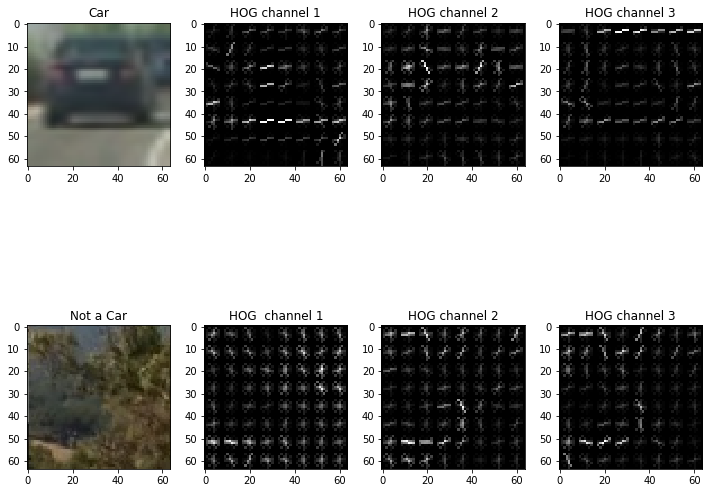

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(10,10))
fig.subplots_adjust(hspace=0.1, wspace=0.2)
axes.flat[0].set_title('Car')
axes.flat[0].imshow(test_car)

axes.flat[1].set_title('HOG channel 1')
axes.flat[1].imshow(img_ch1, cmap='gray')

axes.flat[2].set_title('HOG channel 2')
axes.flat[2].imshow(img_ch2, cmap='gray')

axes.flat[3].set_title('HOG channel 3')
axes.flat[3].imshow(img_ch3, cmap='gray')



axes.flat[4].set_title('Not a Car')
axes.flat[4].imshow(test_not_car)

axes.flat[5].set_title('HOG  channel 1')
axes.flat[5].imshow(img_ch1_nc, cmap='gray')

axes.flat[6].set_title('HOG channel 2')
axes.flat[6].imshow(img_ch2_nc, cmap='gray')

axes.flat[7].set_title('HOG channel 3')
axes.flat[7].imshow(img_ch3_nc, cmap='gray')
fig.tight_layout()
#plt.savefig('Hog.jpg')
plt.show()


In [9]:
# Define a function to compute color histogram features  
def color_histogram(image, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(image[:,:,0], bins=32, range=(0, 256))
    ghist = np.histogram(image[:,:,1], bins=32, range=(0, 256))
    bhist = np.histogram(image[:,:,2], bins=32, range=(0, 256))
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features


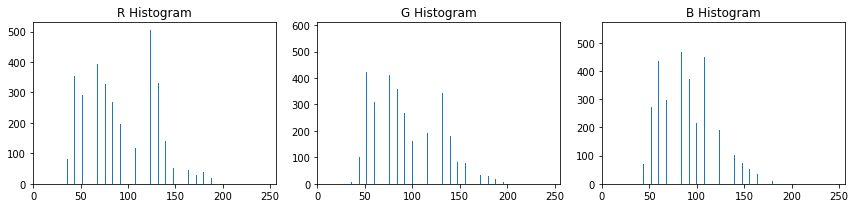

In [10]:
image =cv2.imread(cars[1])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
rh, gh, bh, bincen, feature_vec = color_histogram(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
    plt.savefig('Colorhist.jpg')
else:
    print('Your function is returning None for at least one variable...')

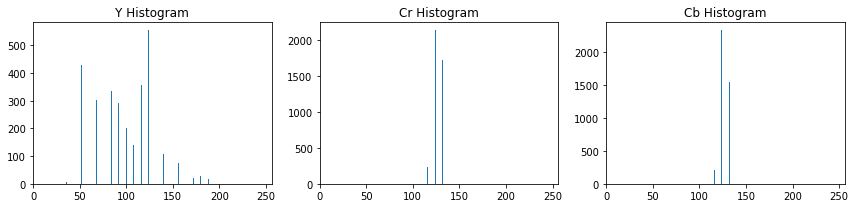

In [11]:
cv2.COLOR_RGB2YCrCb
image =cv2.imread(cars[1])
image=cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
rh, gh, bh, bincen, feature_vec = color_histogram(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('Y Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('Cr Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('Cb Histogram')
    fig.tight_layout()
    plt.savefig('ColorhistYCrCb.jpg')
else:
    print('Your function is returning None for at least one variable...')

In [12]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


In [14]:
svc = LinearSVC()
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test)*100, 2),'%')

Test Accuracy of SVC =  99.3 %


In [15]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows    


In [16]:
#different scales to analyse the features in an image
scales = [0.75, 1, 1.25, 1.5]

In [25]:
def find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                spatial_size, hist_bins):
    
    
    draw_img = np.copy(image)
    img = image.astype(np.float32)/255
    #region of interest 
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    

    imshape = ctrans_tosearch.shape
    if scale != 1:
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), (np.int(imshape[0]/scale))))

    #Blocks of the entire region of interest
    nx_blocks = (ctrans_tosearch.shape[1]//pix_per_cell) - cell_per_block + 1
    ny_blocks = (ctrans_tosearch.shape[0]//pix_per_cell) - cell_per_block + 1
    
    #Window without steps
    window = 64
    window_blocks = (window//pix_per_cell) - cell_per_block + 1
    cell_per_window = window//pix_per_cell
    x_windows = ctrans_tosearch.shape[1]//window
    y_windows = ctrans_tosearch.shape[0]//window
    
    #With steps
    cell_per_step = 2
    step_per_window = cell_per_window//cell_per_step
    nxsteps = (x_windows-1)*step_per_window
    nysteps = (y_windows-1)*step_per_window
    
    #Extract hog features without feature vector in all channel  
    hog1 = get_hog_features(ctrans_tosearch[:,:,0], orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ctrans_tosearch[:,:,1], orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ctrans_tosearch[:,:,2], orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    car_boxes = []
    for xstep in range(nxsteps):
        for ystep in range(nysteps):
            #Cell position
            ypos = ystep*cell_per_step
            xpos = xstep*cell_per_step
            #Extract HOG for each step
            hog_feat1 = hog1[ypos:ypos+window_blocks, xpos:xpos+window_blocks].ravel()
            hog_feat2 = hog2[ypos:ypos+window_blocks, xpos:xpos+window_blocks].ravel()
            hog_feat3 = hog3[ypos:ypos+window_blocks, xpos:xpos+window_blocks].ravel()
            hog_features = np.hstack((hog_feat1,hog_feat2,hog_feat3))
            
            #Pixel position
            x_left = xpos*pix_per_cell
            y_top = ypos*pix_per_cell
            
            #Window Image
            sub_img = cv2.resize(ctrans_tosearch[y_top:y_top+window, x_left:x_left+window],(64,64))
            
            #Spatial and Color Features
            spatial_features = bin_spatial(sub_img, size=spatial_size)
            hist_features = color_hist(sub_img, nbins=hist_bins)
            #Combine test features
            test_features = X_scaler.transform(np.concatenate((spatial_features,hist_features,hog_features)).reshape(1,-1))
            
            prediction = svc.predict(test_features)
            if prediction == 1:
                xleft_draw = np.int(x_left*scale)
                ytop_draw = np.int(y_top*scale) + ystart
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xleft_draw,ytop_draw), (xleft_draw+win_draw, ytop_draw+win_draw),(0,0,255),6)
                car_boxes.append(((xleft_draw,ytop_draw),(xleft_draw+win_draw, ytop_draw+win_draw)))
    
    #return draw_img,car_boxes
    return car_boxes

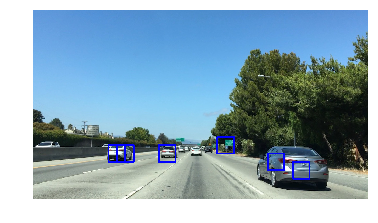

In [24]:
image = mpimg.imread('bbox-example-image.jpg')

draw_image = np.copy(image)

image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.axis('off')
plt.savefig('withWindows.jpg')
plt.show()



In [30]:
image = mpimg.imread('bbox-example-image.jpg')
#image=mpimg.imread('/Users/Enkay/Documents/Viky/python/self-driving/vehicledetection/CarND-Vehicle-Detection/test_images/test1.jpg')  


In [35]:
image.shape

(720, 1280, 3)

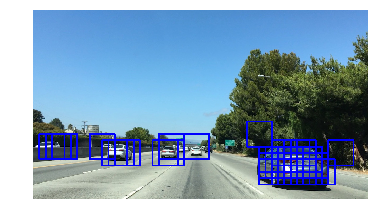

In [34]:
car_img,b_box=find_cars(image, 400, 700, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                spatial_size, hist_bins)
plt.imshow(car_img)
plt.axis('off')
plt.savefig('withHogSubsampling.jpg')

In [33]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img



(-0.5, 1279.5, 719.5, -0.5)

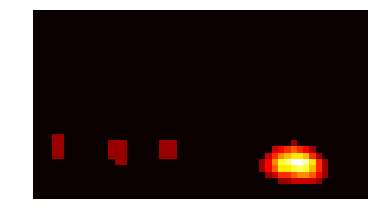

In [45]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat,b_box)
    
# threshold to remove false positives
heat = apply_threshold(heat,2)

# Visualizing the heatmap  
heatmap = np.clip(heat, 0, 255)
plt.imshow(heatmap, cmap='hot')
plt.axis('off')
#plt.savefig('with_heat_map')

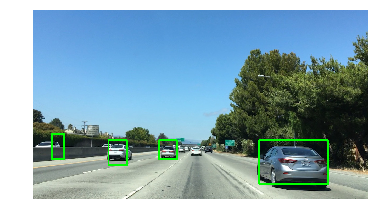

In [46]:
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)
plt.imshow(draw_img)        
plt.axis('off')
plt.savefig('finalImage.jpg')

In [ ]:
def process(image_car):    
    box_list=[]
    for scale in scales:
        box_list.extend(find_cars(image_car, 400, 700, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                spatial_size, hist_bins))
    heat = np.zeros_like(image_car[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list)
    heat = apply_threshold(heat,4)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image_car), labels)
    return draw_img
    

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_output = 'project_vid.mp4'
clip1 = VideoFileClip('project_video.mp4')
project_clip = clip1.fl_image(process)
%time project_clip.write_videofile(project_output, audio=False)